<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>

В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [1]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [2]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

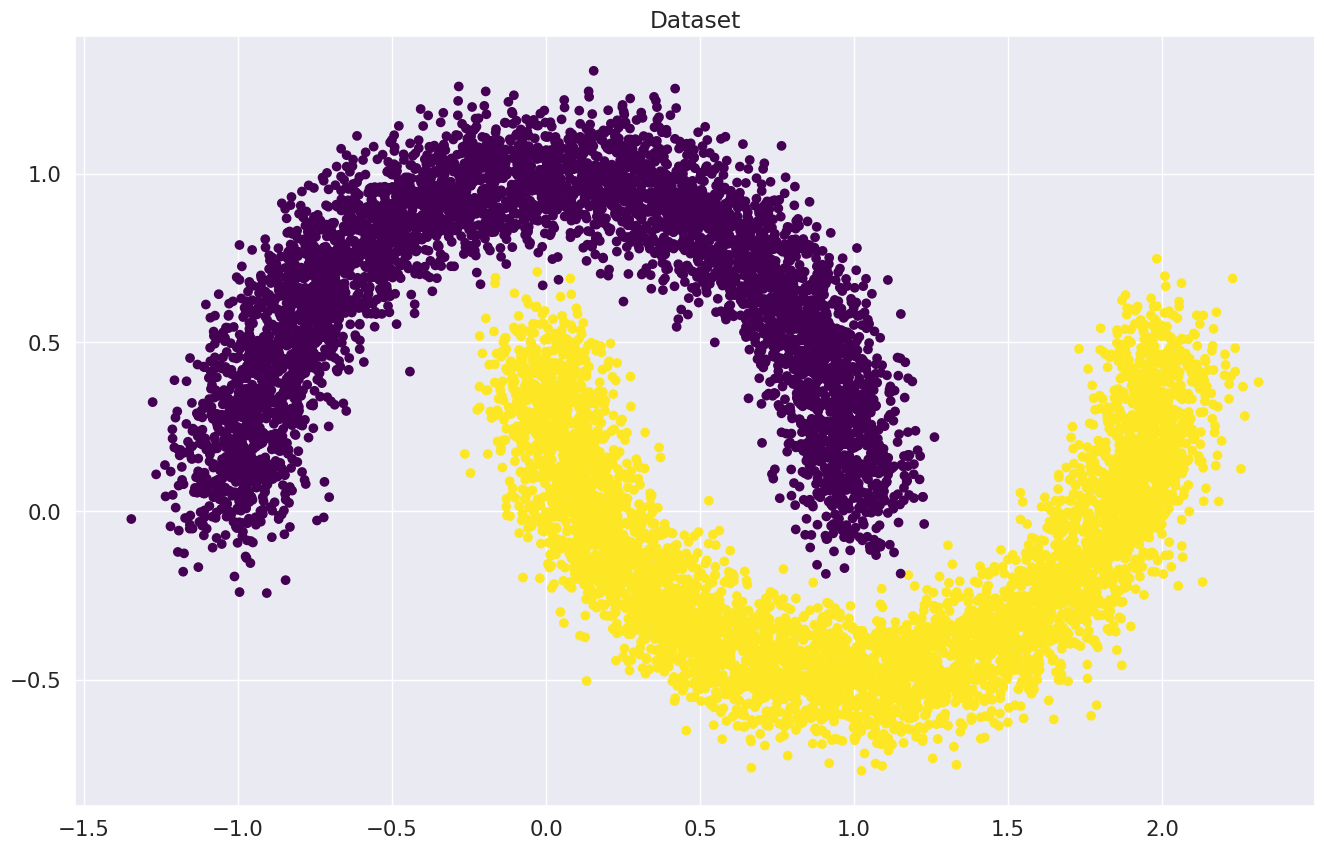

In [3]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [5]:
X_train_t =  torch.from_numpy(X_train.astype(np.float32))
y_train_t =  torch.LongTensor(y_train)
X_val_t =  torch.from_numpy(X_val.astype(np.float32))
y_val_t =  torch.LongTensor(y_val)

Создаем `Dataset` и `DataLoader`.

In [6]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

In [7]:
X_train_t.shape

torch.Size([7500, 2])

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [8]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features, out_features), requires_grad=True)
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(out_features), requires_grad=True)
        #self.Parameters = nn.ParameterList(self.weights, self.bias_term)

    def forward(self, x):
        x =  x @ self.weights
        if self.bias:
            x +=  self.bias_term
        return x

In [9]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели? Имеется в виду суммарное количество отдельных числовых переменных, а не количество тензоров.

In [10]:
list(linear_regression.parameters())

[Parameter containing:
 tensor([[-2.2212],
         [-0.3860]], requires_grad=True),
 Parameter containing:
 tensor([0.3765], requires_grad=True)]

__Ответ 1.__ У модели 3 параметра: 2 веса и 1 смещение

### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [11]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp = linear_regression(X_batch)
        loss = loss_function(outp.reshape(-1), y_batch.float())
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities = torch.sigmoid(outp)
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)

        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.359375
Iteration: 100
Batch accuracy: 0.8046875
Iteration: 200
Batch accuracy: 0.8671875
Iteration: 300
Batch accuracy: 0.9140625
Iteration: 400
Batch accuracy: 0.8984375
Iteration: 500
Batch accuracy: 0.9140625
Iteration: 600
Batch accuracy: 0.8828125

Iteration: 637.Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:** 637

### Визуализируем результаты

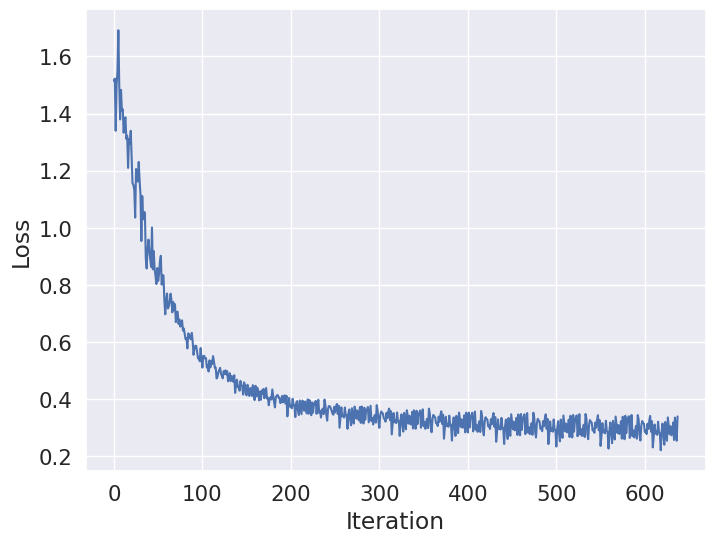

In [12]:
plt.figure(figsize=(8, 6))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

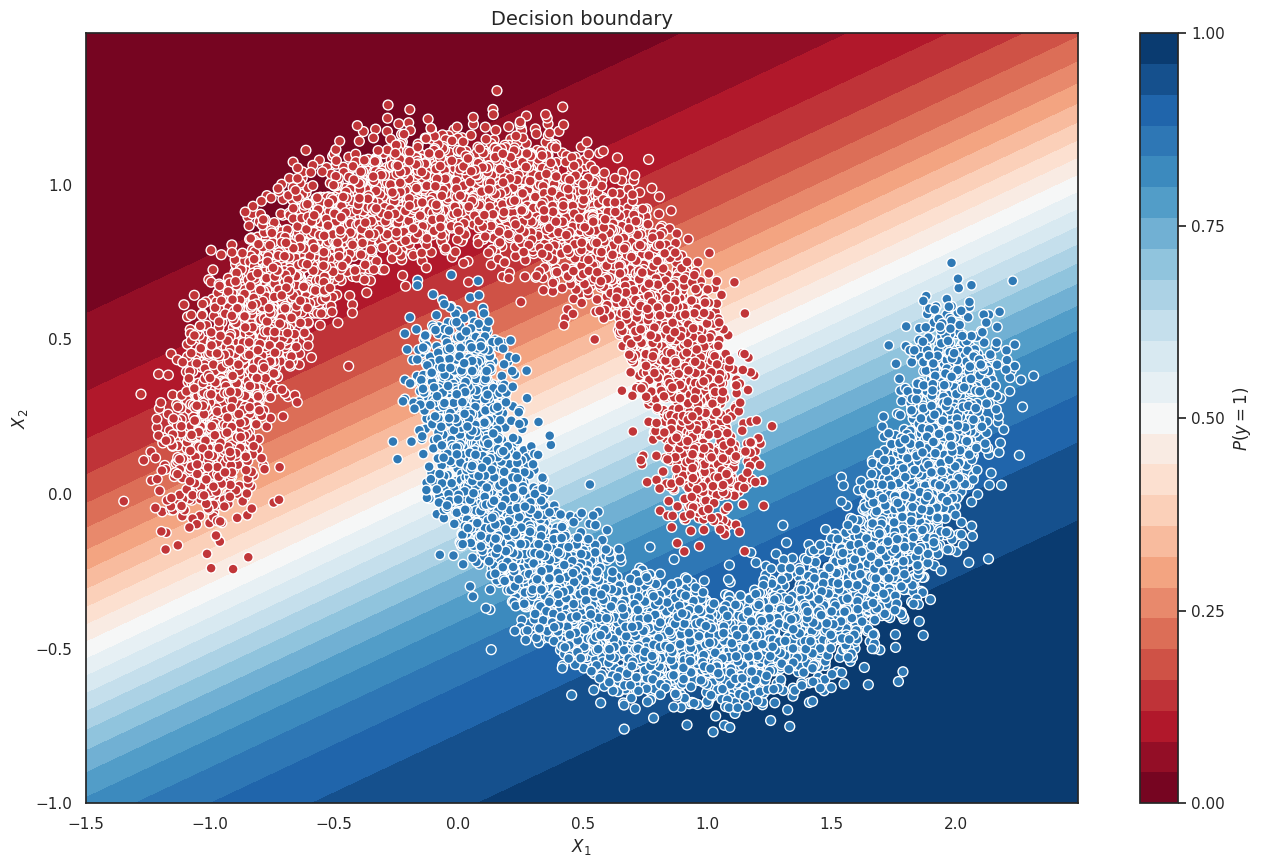

In [13]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [14]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        probabilities = torch.sigmoid(model(x_batch))
        preds = torch.round(probabilities)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [15]:
val_dataloader.dataset.tensors

(tensor([[ 0.7924, -0.5816],
         [ 1.5520, -0.2511],
         [-1.0135,  0.2440],
         ...,
         [ 1.0749, -0.5769],
         [ 0.5422,  0.7608],
         [-0.2381,  1.0917]]),
 tensor([1, 1, 0,  ..., 1, 0, 0]))

In [16]:
y_true = torch.LongTensor()
for x_batch_val, y_batch_val in val_dataloader:
    y_true = torch.cat((y_true, y_batch_val), dim=0)
    print(y_batch.shape)
print(y_true.shape)

torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([2500])


In [17]:
from sklearn.metrics import accuracy_score

y_pred = predict(val_dataloader, linear_regression)
accuracy = accuracy_score(y_val, y_pred)
print(f"accuracy score = {accuracy}")

accuracy score = 0.8784


In [18]:
accuracy = accuracy_score(y_true, y_pred)
print(f"accuracy score = {accuracy}")

accuracy score = 0.8784


**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:** 0.8784

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [19]:
import os
from torchvision.datasets import MNIST
from torchvision import transforms as tfs


data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader =  DataLoader(train_dataset, shuffle=True, batch_size=128, num_workers=2)
valid_dataloader =  DataLoader(val_dataset, shuffle=False, batch_size=128, num_workers=2)

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


(28, 28)


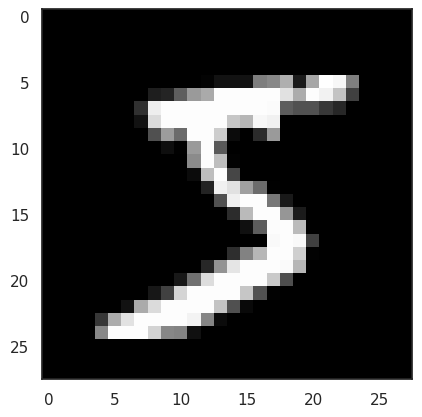

In [20]:
# преобразовать тензор в np.array
numpy_img = train_dataloader.dataset.train_data[0].numpy()
print(numpy_img.shape)
plt.imshow(numpy_img, cmap='gray');

## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [21]:
n_pixels = 28 * 28
n_classes = 10

class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [22]:
activation = nn.ELU

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(n_pixels, 128),
    nn.ELU(),
    nn.Linear(128, 128),
    nn.ELU(),
    nn.Linear(128, n_classes)
    #nn.Softmax(128, 10)
)

In [23]:
model

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ELU(alpha=1.0)
  (3): Linear(in_features=128, out_features=128, bias=True)
  (4): ELU(alpha=1.0)
  (5): Linear(in_features=128, out_features=10, bias=True)
)

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [25]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [26]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                 # Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
                 model.train()
                 optimizer.zero_grad()
                 outp = model(x_batch)
            else:
                 # Set model to ``eval`` mode and calculate outputs
                 model.eval()
                 with torch.no_grad():
                      outp = model(x_batch)

            preds = outp.argmax(-1)
            correct = (preds==y_batch).sum()
            all = outp.shape[0]
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.8864166666666666
Loader: valid. Accuracy: 0.9368
Epoch: 2
Loader: train. Accuracy: 0.94615
Loader: valid. Accuracy: 0.9579
Epoch: 3
Loader: train. Accuracy: 0.963
Loader: valid. Accuracy: 0.9635
Epoch: 4
Loader: train. Accuracy: 0.9705666666666667
Loader: valid. Accuracy: 0.9626
Epoch: 5
Loader: train. Accuracy: 0.9750666666666666
Loader: valid. Accuracy: 0.9688
Epoch: 6
Loader: train. Accuracy: 0.9796666666666667
Loader: valid. Accuracy: 0.9743
Epoch: 7
Loader: train. Accuracy: 0.9816166666666667
Loader: valid. Accuracy: 0.9632
Epoch: 8
Loader: train. Accuracy: 0.9832666666666666
Loader: valid. Accuracy: 0.975
Epoch: 9
Loader: train. Accuracy: 0.98505
Loader: valid. Accuracy: 0.9761
Epoch: 10
Loader: train. Accuracy: 0.9875833333333334
Loader: valid. Accuracy: 0.9773


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [27]:
elu_accuracy = accuracy["valid"]

In [28]:
# YOUR CODE. Do the same thing with other activations (it's better to wrap into a function that returns a list of accuracies)

def test_activation_function(activation):
    activation_func = activation()
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(n_pixels, 128),
        activation_func,
        nn.Linear(128, 128),
        activation_func,
        nn.Linear(128, n_classes)
        )

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())

    loaders = {"train": train_dataloader, "valid": valid_dataloader}
    device = "cuda" if torch.cuda.is_available() else "cpu"

    max_epochs = 10
    accuracy = {"train": [], "valid": []}

    for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:
                if k == "train":
                    # Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
                    model.train()
                    optimizer.zero_grad()
                    outp = model(x_batch)
                else:
                    # Set model to ``eval`` mode and calculate outputs
                    model.eval()
                    with torch.no_grad():
                          outp = model(x_batch)

                preds = outp.argmax(-1)
                correct = (preds==y_batch).sum()
                all = outp.shape[0]
                epoch_correct += correct.item()
                epoch_all += all
                if k == "train":
                    loss = criterion(outp, y_batch)
                    loss.backward()
                    optimizer.step()
            if k == "train":
                print(f"Epoch: {epoch+1}")
            print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
            accuracy[k].append(epoch_correct/epoch_all)

    return accuracy

In [29]:
plain_accuracy = test_activation_function(Identical)

Epoch: 1
Loader: train. Accuracy: 0.8731166666666667
Loader: valid. Accuracy: 0.9105
Epoch: 2
Loader: train. Accuracy: 0.90155
Loader: valid. Accuracy: 0.9096
Epoch: 3
Loader: train. Accuracy: 0.9059833333333334
Loader: valid. Accuracy: 0.9053
Epoch: 4
Loader: train. Accuracy: 0.9087
Loader: valid. Accuracy: 0.9157
Epoch: 5
Loader: train. Accuracy: 0.90885
Loader: valid. Accuracy: 0.9068
Epoch: 6
Loader: train. Accuracy: 0.9144166666666667
Loader: valid. Accuracy: 0.9031
Epoch: 7
Loader: train. Accuracy: 0.9141666666666667
Loader: valid. Accuracy: 0.916
Epoch: 8
Loader: train. Accuracy: 0.91465
Loader: valid. Accuracy: 0.9077
Epoch: 9
Loader: train. Accuracy: 0.9141333333333334
Loader: valid. Accuracy: 0.9169
Epoch: 10
Loader: train. Accuracy: 0.9155166666666666
Loader: valid. Accuracy: 0.9197


In [30]:
relu_accuracy = test_activation_function(nn.ReLU)
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU)

Epoch: 1
Loader: train. Accuracy: 0.8745333333333334
Loader: valid. Accuracy: 0.9286
Epoch: 2
Loader: train. Accuracy: 0.93705
Loader: valid. Accuracy: 0.9509
Epoch: 3
Loader: train. Accuracy: 0.9534333333333334
Loader: valid. Accuracy: 0.957
Epoch: 4
Loader: train. Accuracy: 0.9629666666666666
Loader: valid. Accuracy: 0.9677
Epoch: 5
Loader: train. Accuracy: 0.9701166666666666
Loader: valid. Accuracy: 0.9677
Epoch: 6
Loader: train. Accuracy: 0.9738833333333333
Loader: valid. Accuracy: 0.9673
Epoch: 7
Loader: train. Accuracy: 0.9758166666666667
Loader: valid. Accuracy: 0.9724
Epoch: 8
Loader: train. Accuracy: 0.9795333333333334
Loader: valid. Accuracy: 0.9699
Epoch: 9
Loader: train. Accuracy: 0.9799
Loader: valid. Accuracy: 0.9725
Epoch: 10
Loader: train. Accuracy: 0.9836666666666667
Loader: valid. Accuracy: 0.9745
Epoch: 1
Loader: train. Accuracy: 0.8793666666666666
Loader: valid. Accuracy: 0.9344
Epoch: 2
Loader: train. Accuracy: 0.9423333333333334
Loader: valid. Accuracy: 0.9554
Epo

In [31]:
elu_accuracy = test_activation_function(nn.ELU)

Epoch: 1
Loader: train. Accuracy: 0.8853
Loader: valid. Accuracy: 0.9336
Epoch: 2
Loader: train. Accuracy: 0.9485166666666667
Loader: valid. Accuracy: 0.9572
Epoch: 3
Loader: train. Accuracy: 0.96315
Loader: valid. Accuracy: 0.9646
Epoch: 4
Loader: train. Accuracy: 0.9703166666666667
Loader: valid. Accuracy: 0.9699
Epoch: 5
Loader: train. Accuracy: 0.97555
Loader: valid. Accuracy: 0.9712
Epoch: 6
Loader: train. Accuracy: 0.97885
Loader: valid. Accuracy: 0.9732
Epoch: 7
Loader: train. Accuracy: 0.98185
Loader: valid. Accuracy: 0.9751
Epoch: 8
Loader: train. Accuracy: 0.9836
Loader: valid. Accuracy: 0.9726
Epoch: 9
Loader: train. Accuracy: 0.9860833333333333
Loader: valid. Accuracy: 0.972
Epoch: 10
Loader: train. Accuracy: 0.9855
Loader: valid. Accuracy: 0.9745


In [32]:
elu_accuracy

{'train': [0.8853,
  0.9485166666666667,
  0.96315,
  0.9703166666666667,
  0.97555,
  0.97885,
  0.98185,
  0.9836,
  0.9860833333333333,
  0.9855],
 'valid': [0.9336,
  0.9572,
  0.9646,
  0.9699,
  0.9712,
  0.9732,
  0.9751,
  0.9726,
  0.972,
  0.9745]}

### Accuracy
Построим график accuracy/epoch для каждой функции активации.

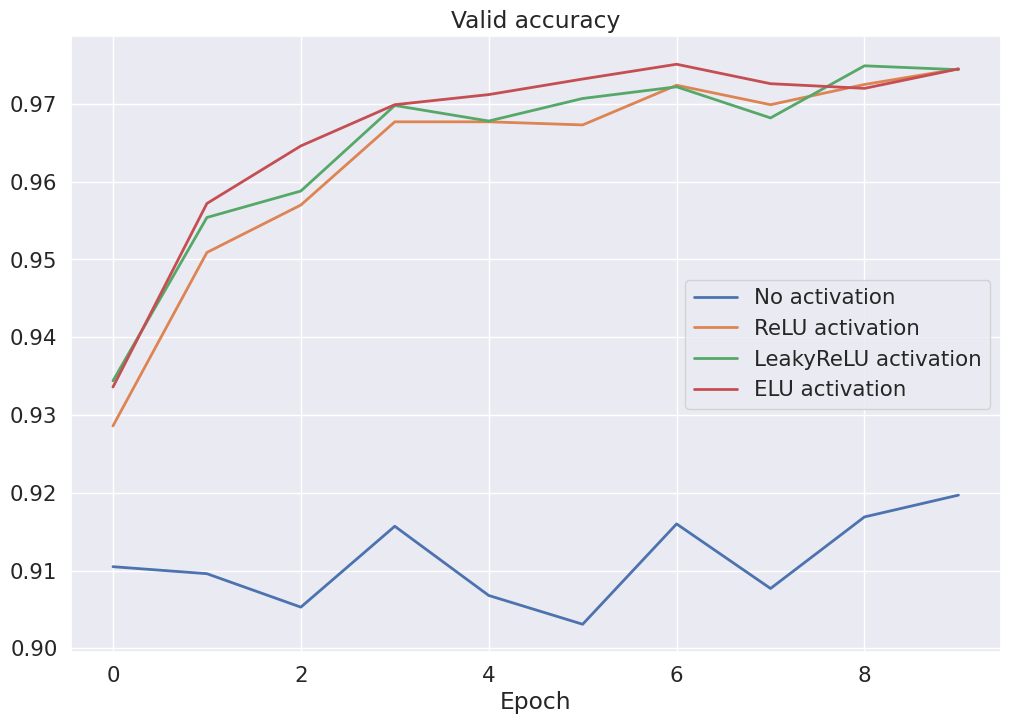

In [33]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(12, 8))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy['valid'], label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy['valid'], label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy['valid'], label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy['valid'], label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

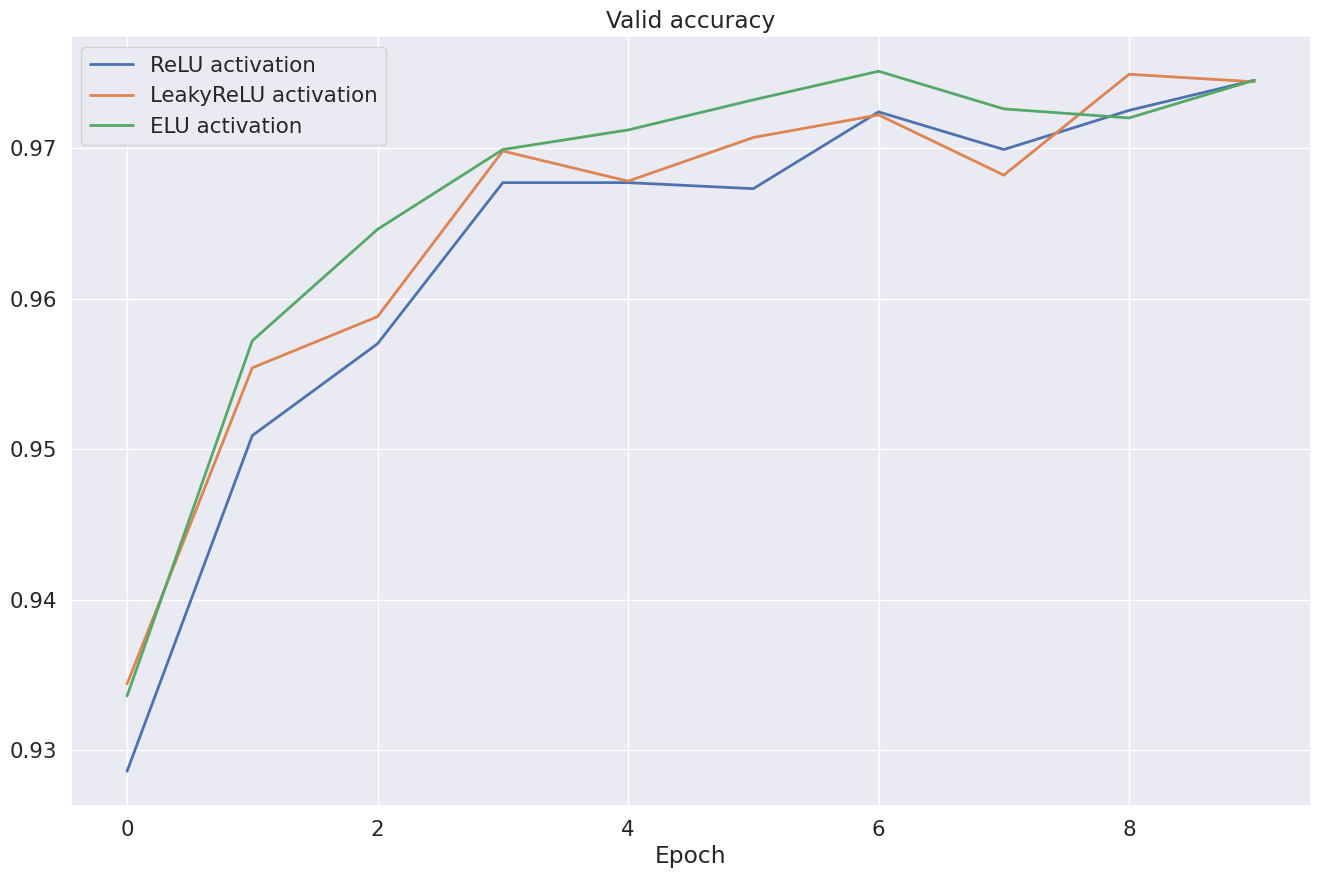

In [34]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy['valid'], label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy['valid'], label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy['valid'], label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

In [52]:
# При предыдущем запуске получалось однозначно ELU

print(f"ReLU accuracy = {relu_accuracy['valid'][-1]}")
print(f"Leaky ReLU accuracy = {leaky_relu_accuracy['valid'][-1]}")
print(f"ELU accuracy = {elu_accuracy['valid'][-1]}")

ReLU accuracy = 0.9745
Leaky ReLU accuracy = 0.9744
ELU accuracy = 0.9745


**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:** ELU (ReLU)

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [35]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2023-11-04 17:25:05--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 5.9.226.237
Connecting to img.the-village.kz (img.the-village.kz)|5.9.226.237|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48.18K   210KB/s    in 0.2s    

2023-11-04 17:25:06 (210 KB/s) - ‘sample_photo.jpg’ saved [49337/49337]



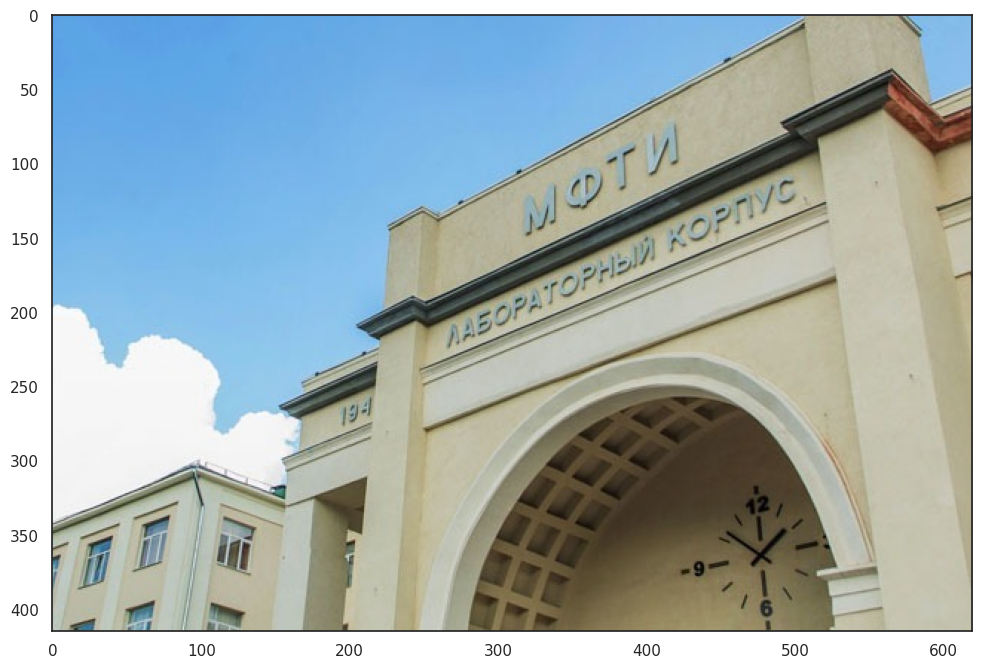

In [36]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

In [37]:
type(RGB_img)

numpy.ndarray

In [38]:
def plot_after_convolution(input_image: np.ndarray, filter_kernel: list) -> None:
    img_t = torch.from_numpy(input_image).type(torch.float32).unsqueeze(0)
    kernel = torch.tensor([
        filter_kernel
    ]).reshape(1, 1, 3, 3).type(torch.float32)

    kernel = kernel.repeat(3, 3, 1, 1)
    img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
    img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

    result = F.conv2d(img_t, kernel)[0]  #

    plt.figure(figsize=(12, 8))
    result_np = result.permute(1, 2, 0).numpy() / 256 / 3

    plt.imshow(result_np)
    plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [39]:
print('А')
plot_after_convolution(RGB_img,
                       [[0, 0, 0],
                        [0, 1, 0],
                        [0, 0, 0]])

print('Б')
plot_after_convolution(RGB_img,
                       [[0, 1, 0],
                        [0, -2, 0],
                        [0, 1, 0]])

print('В')
plot_after_convolution(RGB_img,
                       [[0, 0, 0],
                        [1, -2, 1],
                        [0, 0, 0]])

print('Г')
plot_after_convolution(RGB_img,
                       [[0, 1, 0],
                        [1, -4, 1],
                        [0, 1, 0]])

print('Д')
plot_after_convolution(RGB_img,
                       [[0, -1, 0],
                        [-1, 5, -1],
                        [0, -1, 0]])

print('Е')
plot_after_convolution(RGB_img,
                       [[0.0625, 0.125, 0.0625],
                        [0.125, 0.25, 0.125],
                        [0.0625, 0.125, 0.0625]])

Output hidden; open in https://colab.research.google.com to view.

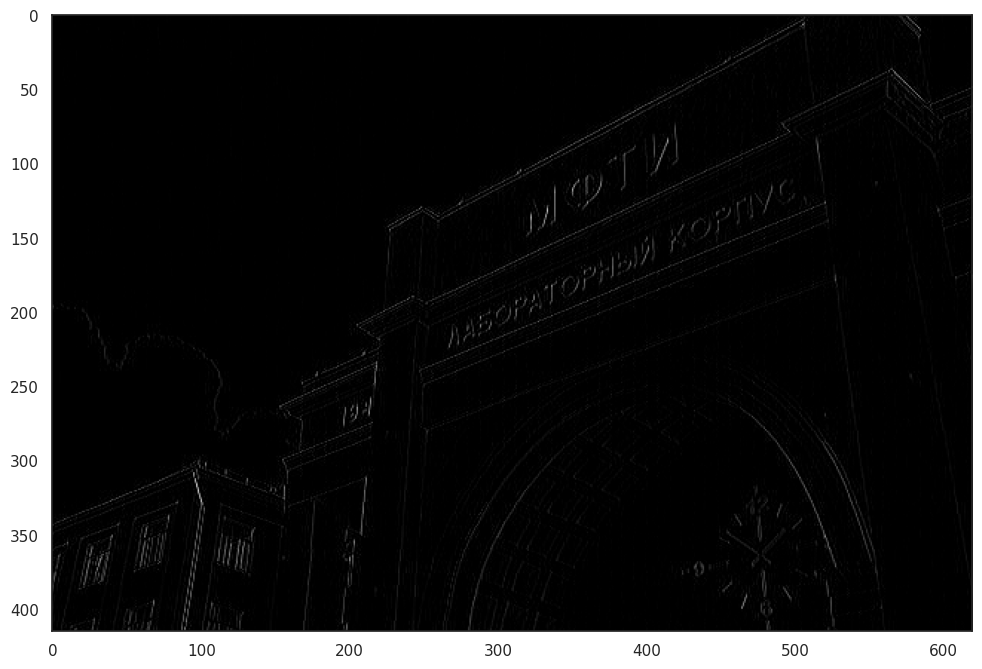

In [40]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
    [0, 0, 0],
    [1, -2, 1],
    [0, 0, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

**Ответ:**
А -- 3<br>
Б -- 5<br>
В -- 4<br>
Г -- 6<br>
Д -- 2<br>
Е -- 1<br>

### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential).

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [41]:
import torch.nn as nn
import torch.nn.functional as F  # Functional
from torchsummary import summary

In [42]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        # print(x.shape)
        x = x.view(-1, 5 * 5 * 16)  # !!!
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [43]:
net = LeNet()
summary(net, (1,28, 28)) # net.cuda(),

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 26, 26]              60
         MaxPool2d-2            [-1, 6, 13, 13]               0
            Conv2d-3           [-1, 16, 11, 11]             880
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 60,074
Trainable params: 60,074
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.23
Estimated Total Size (MB): 0.29
----------------------------------------------------------------


In [44]:
#batch = []
#batch = next(iter(train_dataloader))
#net.forward(torch.FloatTensor(batch[0])) # .cuda()

In [45]:
model = LeNet()#.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [46]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                 # Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
                 model.train()
                 optimizer.zero_grad()
                 outp = model(x_batch)
            else:
                 # Set model to ``eval`` mode and calculate outputs
                 model.eval()
                 with torch.no_grad():
                      outp = model(x_batch)

            preds = outp.argmax(-1)
            correct = (preds==y_batch).sum()
            all = outp.shape[0]
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.8603
Loader: valid. Accuracy: 0.9593
Epoch: 2
Loader: train. Accuracy: 0.9673333333333334
Loader: valid. Accuracy: 0.9775
Epoch: 3
Loader: train. Accuracy: 0.9773666666666667
Loader: valid. Accuracy: 0.9771
Epoch: 4
Loader: train. Accuracy: 0.98185
Loader: valid. Accuracy: 0.979
Epoch: 5
Loader: train. Accuracy: 0.9847333333333333
Loader: valid. Accuracy: 0.9839
Epoch: 6
Loader: train. Accuracy: 0.9867166666666667
Loader: valid. Accuracy: 0.985
Epoch: 7
Loader: train. Accuracy: 0.9885166666666667
Loader: valid. Accuracy: 0.9855
Epoch: 8
Loader: train. Accuracy: 0.9904
Loader: valid. Accuracy: 0.9868
Epoch: 9
Loader: train. Accuracy: 0.9907166666666667
Loader: valid. Accuracy: 0.9865
Epoch: 10
Loader: train. Accuracy: 0.9925166666666667
Loader: valid. Accuracy: 0.9873


In [47]:
lenet_accuracy = accuracy["valid"]
lenet_accuracy

[0.9593, 0.9775, 0.9771, 0.979, 0.9839, 0.985, 0.9855, 0.9868, 0.9865, 0.9873]

Сравним с предыдущем пунктом

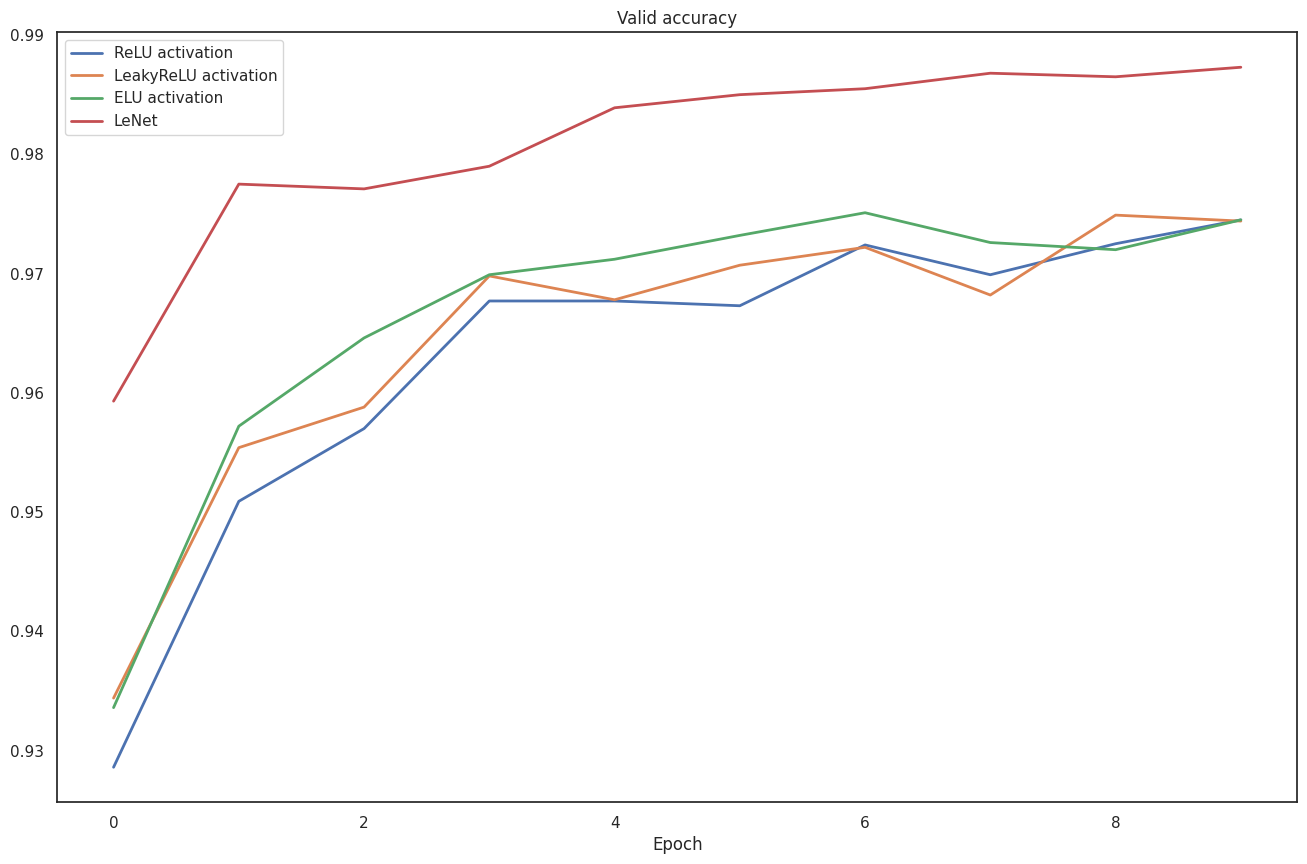

In [49]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy['valid'], label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy['valid'], label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy['valid'], label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

In [50]:
print(f'LeNet accuracy = {round(lenet_accuracy[-1], 2)}')

LeNet accuracy = 0.99


**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:** 0.99